# **Setup**

In [ ]:
!git clone https://github.com/dvschultz/stylegan2-ada-pytorch/
!git clone https://github.com/rosinality/stylegan2-pytorch
!pip install ninja

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 544, done.
remote: Total 544 (delta 0), reused 0 (delta 0), pack-reused 544
Receiving objects: 100% (544/544), 8.42 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (308/308), done.
Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395
Receiving objects: 100% (395/395), 122.51 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (205/205), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 12.2 MB/s eta 0:00:00


In [ ]:
%cd /content/stylegan2-ada-pytorch/
!python export_weights.py https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl /content/saved_model.pkl

/content/stylegan2-ada-pytorch


In [ ]:
%cd /content
# Folders for the trained models and training information.
!mkdir results
%cd ./results
!mkdir checkpoints
!mkdir normalize_losses
!mkdir absolute_losses
!mkdir final_loss
%cd /content/stylegan2-pytorch/

/content
/content/results
/content/stylegan2-pytorch


In [ ]:
# Without this there is a problem with import some models.
!python generate.py --size 1024 --pics 1 --ckpt /content/saved_model.pkl --truncation 0.5

  0% 0/1 [00:00<?, ?it/s]/content/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu116. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
100% 1/1 [00:03<00:00,  3.79s/it]


# **Main Code**

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
import torch
from model import Generator, StyledConv
from torch import Tensor
from typing import Optional, Tuple, List, Union
import pickle
import math


# Generator with bottleneck at the given block_index.
# In this class and in general in this code block_index refers to the index of StyledConv block in the generator.
class GeneratorWithBottleneck(nn.Module):
    def __init__(self, generator: Generator,channels_num: int, block_index:int, validation_size: int=30) -> None:
        super().__init__()
        self.bottleneck=BottleNeck(channels_num, get_channels_num_at_block_index(generator, block_index)).to("cuda")
        self.block_index=block_index
        self.generator=generator
        self.train_normalize_losses=[]
        self.train_absolute_losses=[]

        self.best_validation_loss=float('inf')
        self.validation_set=create_latent_batches_list(generator, length=validation_size)

    def forward(self, latent: Tensor) -> Tensor:
        return forward_with_bottleneck(self.generator, self.bottleneck, self.block_index, latent)
    
    # Return the loss on the validation set of this model.
    def validate(self, save_best_model: bool=False) -> float:
        loss= evaluate_list(self, self.validation_set)
        if loss<self.best_validation_loss and save_best_model:
            self.best_validation_loss=loss
            save_model(self)
        
        return loss
    
    # Returns the input to the bottleneck.
    def get_bottleneck_input(self, latent: Tensor) -> Tensor:
        with torch.no_grad():
            return forward_to_conv(self.generator, self.block_index, latent)

    # Evaluate this model.
    def evaluate(self, batches: int=200, save_evaluation: bool=False) -> float:
        with torch.no_grad():
            return evaluate_generator_with_bottleneck(self, batches=batches, save_evaluation=save_evaluation)
    
    # Saves the model.
    def save(self) -> None:
        save_model(self)
        self.save_train_losses()

    # Saves train_losses.
    def save_train_losses(self) -> None:
        with open(path_to_normalize_losses(self.block_index, self.bottleneck.channels_num), "wb") as fp:   
            pickle.dump(self.train_normalize_losses, fp)
        with open(path_to_absolute_losses(self.block_index, self.bottleneck.channels_num), "wb") as fp:   
            pickle.dump(self.train_absolute_losses, fp)

    # Trains the model.
    def train(self, batches:int =15000) -> None:
        train(self, batches=batches)

    # Returns a latent code for this model.
    def get_latent(self, batch_size=32) -> Tensor:
        return get_latent(self.generator, batch_size)


# The bottleneck network.
class BottleNeck(nn.Module):
    def __init__(self, channels_num: int, original_channels: int) -> None:
        super().__init__()
        self.channels_num = channels_num
        self.original_channels = original_channels
        self.conv1 = nn.Conv2d(original_channels, channels_num, 1, bias=False)
        self.conv2 = nn.Conv2d(channels_num, original_channels, 1, bias=False)

    def forward(self, input: Tensor) -> Tensor:
        return self.conv2(self.conv1(input))

# Saves the model.
def save_model(model: GeneratorWithBottleneck) -> None:
    torch.save({
            'model_state_dict': model.bottleneck.state_dict(),
       }, path_to_checkpoint(model.block_index, model.bottleneck.channels_num))

# Returns the trained model with the given arguments.
def load_model(generator: Generator, channels_num: int, block_index: int) -> GeneratorWithBottleneck:
    model=GeneratorWithBottleneck(generator, channels_num, block_index).to("cuda")
    checkpoint = torch.load(path_to_checkpoint(block_index, channels_num))
    model.bottleneck.load_state_dict(checkpoint['model_state_dict'])
    with open(path_to_normalize_losses(block_index, channels_num), "rb") as fp:   
            model.train_normalize_losses=pickle.load(fp)
    with open(path_to_absolute_losses(block_index, channels_num), "rb") as fp:   
            model.train_absolute_losses=pickle.load(fp)
    model.validation_set=(create_latent_batches_list(generator))
    model.best_validation_loss=evaluate_list(model, model.validation_set)
    return model

# Returns the path to the final_loss identified by block_index and channels_num
def path_to_final_loss(block_index: int, channels_num: int) -> str:
    return "/content/results/final_loss/block_index={}__channels_num={}".format(block_index, channels_num)

# Returns the path to the losses list identified by block_index and channels_num
def path_to_normalize_losses(block_index: int, channels_num: int) -> str:
    return "/content/results/normalize_losses/block_index={}__channels_num={}".format(block_index, channels_num)

# Returns the path to the losses list identified by block_index and channels_num
def path_to_absolute_losses(block_index: int, channels_num: int) -> str:
    return "/content/results/absolute_losses/block_index={}__channels_num={}".format(block_index, channels_num)

# Returns the path to the checkpoint identified by block_index and channels_num
def path_to_checkpoint(block_index: int, channels_num: int) -> str:
    return "/content/results/checkpoints/block_index={}__channels_num={}".format(block_index, channels_num)
# Returns the output channels num of block_index in generator.    
def get_channels_num_at_block_index(generator: Generator, block_index: int) -> int:
    # The index of block_index channels in the channels list of the generator.
    channel_index=int(math.ceil(block_index/2))
    return generator.channels[4*(2**channel_index)]

# Creates a list with batches of latent codes.
def create_latent_batches_list(generator: Generator, batch_size:int=32, length: int=30)-> List[Tensor]:
    validation_set=[]
    for i in range(length):
        validation_set.append(get_latent(generator,batch_size))
    return validation_set

# Given a list of batches returns the loss of the model on this batches.
def evaluate_list(model: GeneratorWithBottleneck, batches: List[Tensor]) -> float:
    loss=0
    total_samples=0
    for batch in batches:
        total_samples+=batch.size(0)
        cur_loss, _=get_reconstruction_loss(model, latent=batch)
        loss+=cur_loss.item()
    loss/=total_samples
    return loss

# Evaluate the loss of model. 
@torch.no_grad() 
def evaluate_generator_with_bottleneck(model: GeneratorWithBottleneck, batches: int=100, batch_size: int=32, save_evaluation: bool =True ) -> float:
    final_loss = 0
    for i in range(batches):
        loss , _= get_reconstruction_loss(model, batch_size)
        final_loss+=loss.item()
    final_loss /= (batches*batch_size)

    if save_evaluation:
        with open(path_to_final_loss(model.block_index, model.bottleneck.channels_num), "wb") as fp:   
            pickle.dump(final_loss, fp)
    return final_loss

# Returns a latent code for the generator.
def get_latent(generator: Generator, batch_size:int =32) -> Tensor:
    style=generator.style(torch.randn(batch_size, 512).to("cuda"))
    latent = style.unsqueeze(1).repeat(1, generator.n_latent, 1)
    return latent

# Given style returns the latent for this generator.
def get_latent_from_style(generator: Generator, style: Tensor) -> Tensor:
    style=generator.style(style)
    latent = style.unsqueeze(1).repeat(1, generator.n_latent, 1)
    return latent

# Retruns [loss, normalize_loss] given a model. 
# The loss is MSE reconstruction of the bottleneck. 
def get_reconstruction_loss(model: GeneratorWithBottleneck, batch_size: int=32, latent: Optional[Tensor]=None) -> Tuple[Tensor, float]:
    if latent is None:
        latent = model.get_latent(batch_size)
    bottle_input=model.get_bottleneck_input(latent)
    bottle_output=model.bottleneck(bottle_input)
    loss=torch.mean((bottle_output - bottle_input)**2)
    normalize_loss=loss.item()/torch.mean(bottle_output**2).item()
    return loss, normalize_loss

# Trains the model (bottleneck) with the given arguments.
def train(model: GeneratorWithBottleneck, optimizer: Optional[Optimizer] = None, batches: int= 15000, batch_size: int=32, 
          report_every: int=10, validation_every: int=100, max_reports_without_improve: int = float('inf'), print_progress=True) -> None:
    if optimizer is None:
        optimizer = optim.Adam(model.bottleneck.parameters(), lr=0.1)
    best_loss = float('inf')
    reports_without_improve = 0
    for it in range(batches):
        optimizer.zero_grad()
        cur_loss, normalize_loss = get_reconstruction_loss(model, batch_size)
        cur_loss.backward()
        optimizer.step()
        if it%report_every==0:
            model.train_absolute_losses.append(cur_loss.item())
            model.train_normalize_losses.append(normalize_loss)
            if print_progress:
                print("   batch {}: {}".format(it,normalize_loss))
            # Stop if there isn't improvement in the loss.
            if best_loss < normalize_loss:
                reports_without_improve += 1
                if reports_without_improve == max_reports_without_improve:
                    break
            else:
                reports_without_improve = 0
                best_loss = normalize_loss
        if it%validation_every==0:
            model.validate(save_best_model=True)

# Forward in the generator to the block_index StyledConv and in this block forward after the convolution.
def forward_to_conv(generator: Generator, block_index: int, 
                    latent: Tensor, ) -> Tensor:
    noise = [
                getattr(generator.noises, f"noise_{i}") for i in range(generator.num_layers)
            ]
    out = generator.input(latent)
    cur_block = 0
    if block_index == cur_block:
        output = to_conv(generator.conv1, out, latent[:, 0])
        return output

    cur_block = 1
    out = generator.conv1(out, latent[:, 0], noise=noise[0])
    skip = generator.to_rgb1(out, latent[:, 1])

    i = 1
    for conv1, conv2, noise1, noise2, to_rgb in zip(
        generator.convs[::2], generator.convs[1::2], noise[1::2], noise[2::2], generator.to_rgbs
    ):
        if cur_block == block_index:
            output = to_conv(conv1, out, latent[:, i])
            return output
        out = conv1(out, latent[:, i], noise=noise1)
        cur_block += 1

        if cur_block == block_index:
            output = to_conv(conv2, out, latent[:, i+1])
            return output
        out = conv2(out, latent[:, i+1], noise=noise2)
        skip = to_rgb(out, latent[:, i + 2], skip)
        cur_block += 1

        i += 2

    image = skip
    return image

# Forward in the generator to the block_index StyledConv and in this block forward after the convolution.
def forward_with_bottleneck(generator: Generator, bottleneck: BottleNeck, block_index: int, 
        latent: Tensor) -> Tensor:

    noise = [
                getattr(generator.noises, f"noise_{i}") for i in range(generator.num_layers)
            ]
    out = generator.input(latent)
    cur_block = 0
    if block_index == cur_block:
        out = forward_style_conv_with_bottleneck(
            generator.conv1, bottleneck, out, latent[:, 0], noise[0])
    else:
        out = generator.conv1(out, latent[:, 0], noise=noise[0])

    skip = generator.to_rgb1(out, latent[:, 1])
    cur_block = 1

    i = 1
    for conv1, conv2, noise1, noise2, to_rgb in zip(
        generator.convs[::2], generator.convs[1::2], noise[1::2], noise[2::2], generator.to_rgbs
    ):
        if cur_block == block_index:
            out = forward_style_conv_with_bottleneck(
                conv1, bottleneck, out, latent[:, i], noise1)
        else:
            out = conv1(out, latent[:, i], noise=noise1)
        cur_block += 1

        if cur_block == block_index:
            out = forward_style_conv_with_bottleneck(
                conv2, bottleneck, out, latent[:, i+1], noise2)
        else:
            out = conv2(out, latent[:, i+1], noise=noise2)
        skip = to_rgb(out, latent[:, i + 2], skip)
        cur_block += 1

        i += 2

    image = skip
    return image

# Returns the output right after the convolution.
def to_conv(style_conv: StyledConv, input: Tensor, style: Tensor) -> Tensor:
    return style_conv.conv(input, style)

# Returns the output from the conv of the style_conv.
def from_conv(style_conv: StyledConv, input: Tensor, noise: Tensor) -> Tensor:
    out = style_conv.noise(input, noise=noise)
    out = style_conv.activate(out)
    return out

# Forward in the style_block from right after the conv layer.
def forward_style_conv_with_bottleneck(style_conv: StyledConv, bottleneck: BottleNeck, input: Tensor, style: Tensor,
                                        noise: Tensor) -> Tensor:
    out = to_conv(style_conv, input, style)
    out = bottleneck(out)
    out = from_conv(style_conv, out, noise)
    return out

In [ ]:
!unzip /content/results.zip -d /content

# **Basic Expirements**

In our basic experiment, we train a bottleneck with different channel numbers in block_index=2.

In [ ]:
# Creates the original generator using stylegan-ada weights.
gen = Generator(size=1024, style_dim=512, n_mlp=8).to("cuda")
checkpoint = torch.load("../saved_model.pkl")
gen.load_state_dict(checkpoint["g_ema"])
gen.eval()
gen.to("cuda")

In [ ]:
channels_list=[512,300,100,50,10,5,1]
block_index=2

for channels_num in channels_list:
  print("Start for {}:".format(channels_num))
  model=GeneratorWithBottleneck(gen, channels_num, block_index)
  model.train(batches=15000)
  model.save_train_losses()
  model.evaluate(batches=500, save_evaluation=True)

In [ ]:
# Download the results.
!zip -r /content/results.zip /content/results

from google.colab import files
files.download("/content/results.zip")

# **Visual Results**

In [ ]:
from PIL import Image
from torchvision.utils import make_grid


# Shows the tensor as an image.
@torch.no_grad()
def show_images(tensors: Union[Tensor, List[Tensor]], nrow: int=1) -> None:
    grid=make_grid(tensors, nrow=nrow, padding=0).permute(1, 2, 0)
    to_numpy=grid.to("cpu", torch.uint8).numpy()
    image = Image.fromarray(to_numpy)
    image.show()

# Decideds a random latent code and show the images the generator create with it without bottleneck and
# With each bottleneck in the list bottlenecks.
# The order of the images is first the generator output and then models by the order.
# We assume here that the models use the given generator. 
@torch.no_grad()
def show_images_with_bottlenecks(generator: Generator, models: List[GeneratorWithBottleneck], latent: Optional[Tensor]=None)-> None:
    if latent is None:
        latent=get_latent(generator, batch_size=1)
    images=[]
    original_image=generator([latent], input_is_latent=True, randomize_noise=False)[0]
    images.append(tensor_to_image_tensor(original_image)[0])
    for model in models:
        output=model(latent)
        images.append(tensor_to_image_tensor(output)[0])
    show_images(images, nrow=len(images))

# Takes a batch of tenstors and return the batch as images.
def tensor_to_image_tensor(tensor: Tensor) -> Tensor:
    for i in range(tensor.size(0)):
        tensor[i] -= torch.min(tensor[i])
        tensor[i] /= torch.max(tensor[i])
    tensor.mul_(255).add_(0.5).clamp_(0, 255)
    return tensor

In [ ]:
show_images_with_bottlenecks(gen, models, latent=get_latent_from_style(gen,data[9]))


# **Numerical results**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
reconstruction_loss=[]
for model in models:
  loss=model.evaluate()
  reconstruction_loss.append(loss)
  print("loss for {} channels: {}".format(model.bottleneck.channels_num, loss))

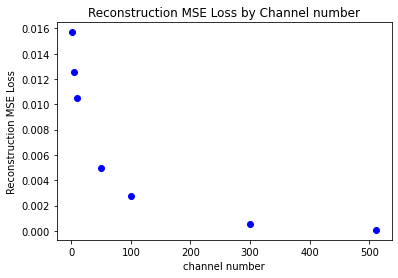

In [ ]:
xpoints = np.array(channels_list)
ypoints = np.array(reconstruction_loss)

plt.plot(xpoints, ypoints, 'bo')
plt.title("Reconstruction MSE Loss by Channel Number")
plt.xlabel("channel number")
plt.ylabel("Reconstruction MSE Loss")

plt.show()

In [ ]:
train_data_list=[]
for model in models:
  train_data_list.append(model.train_normalize_losses)
x_values=[10*(a+1) for a in range(len(train_data_list[0]))]

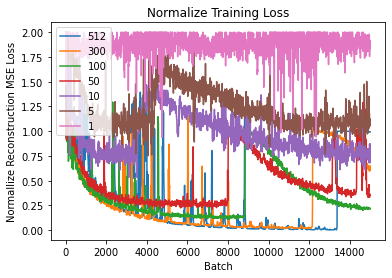

In [ ]:
xpoints = np.array(x_values)
for (loss, chan) in zip(train_data_list, channels_list):
  ypoints=np.clip(np.array(loss),0, 2)
  plt.plot(xpoints, ypoints, label=chan)

plt.title("Normalize Training Loss")
plt.xlabel("Batch")
plt.ylabel("Normallize Reconstruction MSE Loss")
plt.legend(loc='best')

plt.show()

# **FID Calculation**

In [ ]:
!pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.9/305.9 KB 23.6 MB/s eta 0:00:00


In [ ]:
from fid import calc_fid
from calc_inception import load_patched_inception_v3
import numpy as np
import os
import urllib.request
import shutil

# FID calculation with bottleneck.
def calc_fid_with_bottleneck(model: GeneratorWithBottleneck, n_sample:int =50000) -> float:
    inception = nn.DataParallel(load_patched_inception_v3()).to("cuda")
    inception.eval()

    features = extract_feature_from_samples(model, inception, n_sample).numpy()
    sample_mean = np.mean(features, 0)
    sample_cov = np.cov(features, rowvar=False)
    real_mean, real_cov=get_stats()
    fid = calc_fid(sample_mean, sample_cov, real_mean, real_cov)

    return fid

# Given generator and bottleneck extract features for FID calculation.
def extract_feature_from_samples(model: GeneratorWithBottleneck, inception,n_sample, batch_size=32):
    with torch.no_grad():
        n_batch = n_sample // batch_size
        resid = n_sample - (n_batch * batch_size)
        batch_sizes = [batch_size] * n_batch + [resid]
        features = []

        for batch in batch_sizes:
            latent=model.get_latent(batch_size)
            img=model(latent)
            feat = inception(img)[0].view(img.shape[0], -1)
            features.append(feat.to("cpu"))

        features = torch.cat(features, 0)
        return features
    
# Returns the statics for FID calculation.
def get_stats():
    base_url = "https://www.cs.cmu.edu/~clean-fid/stats/"
    rel_path = ("FFHQ_clean_trainval70k_1024.npz").lower()
    url = f"{base_url}/{rel_path}"
    mod_path = os.path.dirname(".")
    stats_folder = os.path.join(mod_path, "stats")
    fpath = check_download_url(local_folder=stats_folder, url=url)
    stats = np.load(fpath)
    mu, sigma = stats["mu"], stats["sigma"]
    return mu, sigma

# Download the information if it doesn't exist.
def check_download_url(local_folder, url):
    name = os.path.basename(url)
    local_path = os.path.join(local_folder, name)
    if not os.path.exists(local_path):
        os.makedirs(local_folder, exist_ok=True)
        print(f"downloading statistics to {local_path}")
        with urllib.request.urlopen(url) as response, open(local_path, 'wb') as f:
            shutil.copyfileobj(response, f)
    return local_path

In [ ]:
fids=[]
for model in models:
  fids.append(calc_fid_with_bottleneck(model))

In [ ]:
xpoints = np.array(channels_list)
ypoints = np.array(fids)

plt.plot(xpoints, ypoints, 'bo')
plt.title("FID by Channel Number")
plt.xlabel("channel number")
plt.ylabel("FID")

plt.show()

# **Find Best Channel Number**

We want to find the minimum channel number where the visual results are still excellent. To do this we can use binary search on the channel number guided by an FID limit.

In [ ]:
# Returns the minimum number of channels where the FID is under the fid_limit.
# The resolution parameter control the max difference from the optimal channels num.
def binary_search(generator: Generator, block_index: int, channel_limit: int, fid_limit: int, resolution: int = 0, 
                  train_batches:int =15000, fid_sampels:int =50000,print_results: bool = True) -> int:
    print("start binary search:")
    high = channel_limit
    low = 1
    mid = 0
    while high-low > resolution*2:
        mid = (high+low)//2
        print("start train on {}".format(mid))
        model=GeneratorWithBottleneck(generator,channels_num = mid, block_index = block_index)
        model.train(batches=train_batches)
        cur_fid=calc_fid_with_bottleneck(model, n_sample=fid_sampels)
        if print_results:
            print("{}: {}".format(mid, cur_fid))
        if cur_fid > fid_limit:
            low = mid+1
        else:
            high = mid
    return (high+low)//2